# Project II: Economic Growth 

### By Astrid Fugleholm, Jacob Strabo, and Jørgen Høst

In [1]:
# Importing packages
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.linear_model import Lasso
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
import geopandas

# Toolbox
import HDmodels as hd

## 1. Read Data

In [2]:
dat = pd.read_csv('growth.csv')
lbldf = pd.read_csv('labels.csv', index_col='variable')
lbl_all = lbldf.label.to_dict() # as a dictionary

print(f'The data contains {dat.shape[0]} rows (countries) and {dat.shape[1]} columns (variables).')

The data contains 214 rows (countries) and 85 columns (variables).


### 1.1 Identify dummy variables

In [3]:
category_features = []
threshold = 2
for each in dat.columns:
    if dat[each].nunique() == threshold:
        category_features.append(each)

for each in category_features:
    dat[each] = dat[each].astype('category')

dummies = dat.select_dtypes('category')

## 2. Descriptive Plots

In [4]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# Fix errors in geopandas (tsk!)
if world.query('name == "France"').iso_a3.values[0] == '-99': 
    world.loc[world.name == "France", 'iso_a3'] = 'FRA'
if world.query('name == "Norway"').iso_a3.values[0] == '-99': 
    world.loc[world.name == "Norway", 'iso_a3'] = 'NOR'

def remove_bounding(ax): 
    ax.set_yticklabels([]);
    ax.set_xticklabels([]); 
    ax.set_xticks([]);
    ax.set_yticks([]);
    for l in ['top', 'bottom', 'left', 'right']:
        ax.spines[l].set_visible(False)

def plot_world_map(var, dat, lbl=None, title=None, fname=None, **kwargs):
    assert var in dat.columns, f'Variable "{var}" not in dat columns'
    assert 'code' in dat.columns , f'ISO3 country variable, "code", not found in dat'
    
    # name for chosen variable 
    lbl_var = var # default: just show the variable name 
    if (not lbl is None): 
        if isinstance(lbl, str): 
            lbl_var = lbl 
        elif var in lbl: 
            lbl_var = lbl[var]
        else: 
            print(f'(Var "{var}" not in lbl)')
        
    cols = ['code'] + [var]
    w = pd.merge(world, dat[cols], left_on='iso_a3', right_on='code')
    ax = w.plot(var, cmap = 'BuPu', legend=True, missing_kwds={'color': 'lightgrey', 'label':'hej'},
                 legend_kwds={'label': lbl_var,'orientation': "horizontal"}, **kwargs);
    remove_bounding(ax)
    if not title is None: 
        ax.set_title(title)
    if not fname is None: 
        plt.savefig(fname)

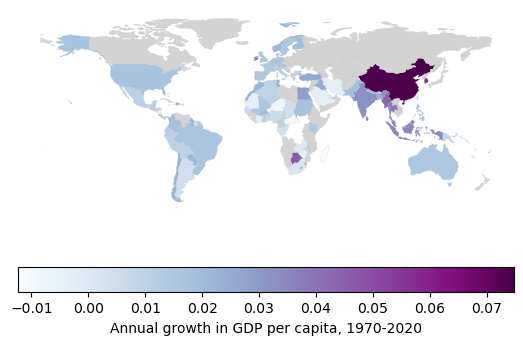

In [5]:
plot_world_map('gdp_growth', dat, lbl=lbl_all, edgecolor=(.7,.7,.7), linewidth=0.1)

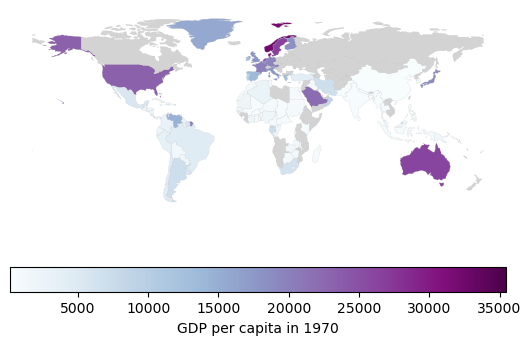

In [6]:
plot_world_map('gdp_pc_initial', dat, lbl=lbl_all, edgecolor=(.7,.7,.7), linewidth=0.1)

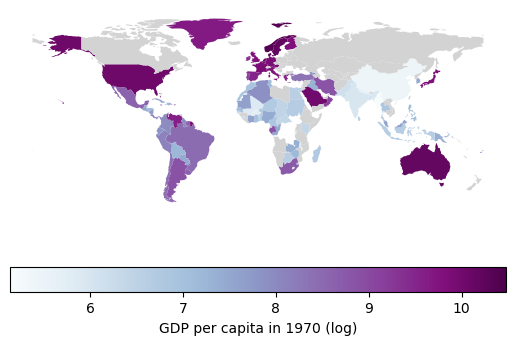

In [7]:
plot_world_map('lgdp_initial', dat, lbl_all)

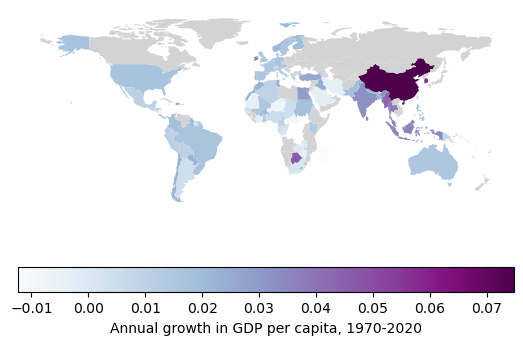

In [8]:
plot_world_map('gdp_growth', dat, lbl_all)

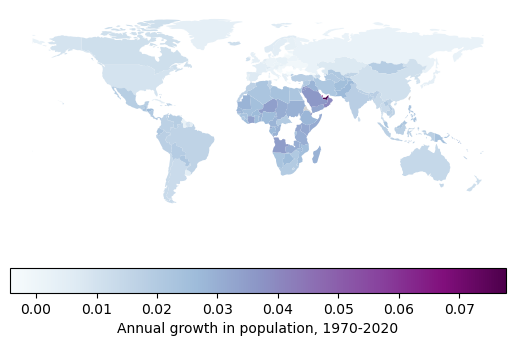

In [9]:
plot_world_map('pop_growth', dat, lbl_all)

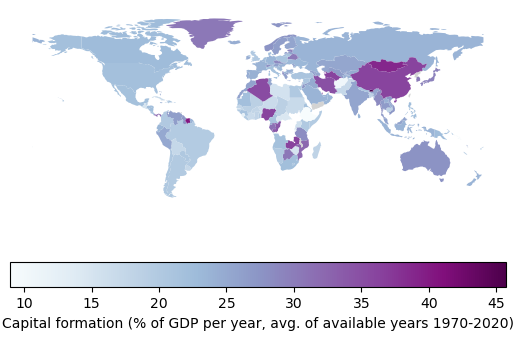

In [10]:
plot_world_map('investment_rate', dat, lbl_all)

## 3. Collection of Variables

In [11]:
# Variables regarding institutions
vv_institutions = ['marketref', 'dem', 'demCGV', 'demBMR', 'demreg'] 

# Variables regarding geography
vv_geography = [
        'tropicar','distr', 'distcr', 'distc','suitavg','temp', 'suitgini', 'elevavg', 'elevstd',
        'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough','landlock', 
        'africa',  'asia', 'oceania', 'americas' # 'europe' is the reference
]

# Variables regarding genetic diversity
vv_geneticdiversity = ['pdiv', 'pdiv_aa', 'pdivhmi', 'pdivhmi_aa']

# Variables regarding historical events
vv_historical = ['pd1000', 'pd1500', 'pop1000', 'pop1500', 'ln_yst'] # these are often missing: ['pd1', 'pop1']

# Variables regarding religion
vv_religion = ['pprotest', 'pcatholic', 'pmuslim']

# Variables regarding the level of danger in countries
vv_danger = ['yellow', 'malfal',  'uvdamage']

# Variables regarding natural resources in countries
vv_resources = ['oilres', 'goldm', 'iron', 'silv', 'zinc']

# Variables regarding educational attainment level of populations in countries 
vv_educ = ['ls_bl', 'lh_bl'] # secondary, tertiary: we exclude 'lp_bl' (primary) to avoid rank failure 

# A collection of all available variables grouped based on category
vv_all = {'institutions': vv_institutions, 
          'geography': vv_geography, 
          'geneticdiversity': vv_geneticdiversity,
          'historical': vv_historical,
          'religion': vv_religion,
          'danger':vv_danger, 
          'resources':vv_resources,
          'educ':vv_educ
         }
list_of_lists = vv_all.values()
vv_all['all'] = [v for sublist in list_of_lists for v in sublist]

### 3.1 Initial Selection of Controls

Method: On the basis of `materialize.ipynb`, select variables that has *at least* 90%-95% non-missing observations of GDP growth.

In [12]:
share_of_non_mis_obs = 0.95

temp = dat[dat.gdp_growth.notnull()].notnull().mean()>share_of_non_mis_obs
temp2 = temp.to_dict()

# Delete vars that has less than 90% non-missing obs for GDP growth
# NB! Not necessarily optimising the number of observations (different pairs could yield the higher number of observations)
for key, val in temp2.copy().items():
    if val == False:
        del temp2[key]

# Save the 'vars' for later
vars_to_keep = list(temp2.keys())

# Pick out those who has been saved in vars_to_keep
var_selection = [item for item in vv_all['all'] if item in vars_to_keep]
var_selection

['demreg',
 'temp',
 'elevavg',
 'precip',
 'area',
 'abslat',
 'cenlong',
 'area_ar',
 'rough',
 'landlock',
 'africa',
 'asia',
 'oceania',
 'americas',
 'pdiv',
 'pdiv_aa',
 'pd1500',
 'pop1500',
 'pprotest',
 'pcatholic',
 'pmuslim',
 'yellow',
 'uvdamage',
 'oilres',
 'goldm',
 'iron',
 'silv',
 'zinc']

In [13]:
## Based on our '95%' rule, select variables ##

# Possible controls (z_i)
z_controls_name =['pop_growth', 'investment_rate']+var_selection

# Initial gdp (y0)
y0_initial_gdp_name = ['lgdp_initial']

# Outcome variable (g) gdp_growth
g_name=['gdp_growth']

# avoiding missings
all_vars = g_name + y0_initial_gdp_name + z_controls_name
I = dat[all_vars].notnull().all(1)

# extract data (We split it up, this makes sense later)
# Possible controls (z_i)
z_i_controls = dat.loc[I, z_controls_name].values  

# Initial GDP (beta), our treatment variable y0
y0 = dat.loc[I, y0_initial_gdp_name].values 

X = dat.loc[I, y0_initial_gdp_name+z_controls_name]
X_vals = dat.loc[I, y0_initial_gdp_name+z_controls_name].values

# Outcome variable is gdp-growth
y = dat.loc[I,g_name].values.reshape((-1,1)) * 100. #easier to read output when growth is in 100%

## Confirm that the first column in our matrix X=((y0,z_i)) is in fact 'initial gdp' ##
pd.DataFrame(X).head(1)

,lgdp_initial,pop_growth,investment_rate,demreg,temp,elevavg,precip,area,abslat,cenlong,...,pprotest,pcatholic,pmuslim,yellow,uvdamage,oilres,goldm,iron,silv,zinc
4,8.865619,0.012921,19.976606,0.071429,13.966665,0.715286,52.905045,2736690.0,34.0,-64.0,...,2.7,91.6,0.2,0.0,170.53558,46900.0,0.0,0.0,0.0,0.0


In [14]:
# Write all variables to table
pd.set_option('display.max_colwidth', 1000)
var_list_table = pd.Series(lbl_all)[all_vars]
with open('variable_table.tex', 'w') as tf:
     tf.write(var_list_table.to_latex())

C:\Users\JBH\AppData\Local\Temp\ipykernel_20884\2835441973.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tf.write(var_list_table.to_latex())


In [15]:

# Add polynomial features and interaction terms
poly = PolynomialFeatures(2, include_bias=False)

# Compute number of output variables, use 'fit()', then extract variable names
# This is helpful later on
var_names_poly = poly.fit(X).get_feature_names_out(X.columns)
var_names = X.columns

# Then, fit polynomial and interaction terms, use 'fit_transform()'
X_poly = poly.fit_transform(X)

# Extract our controls (first column is 'lgdp_initial')
Z_poly_controls = X_poly[:, 1:]

# Standardize our data (including initial GDP) - no interactions / squared terms
X_tilde = hd.standardize(X_vals)
X_tilde_naive = hd.standardize(X_vals[:, 1:])

# Standardize our data (including initial GDP)
X_tilde_poly = hd.standardize(X_poly)

# Not including initial GDP
Z_tilde_poly_naive = hd.standardize(Z_poly_controls)

(N,p) = X_tilde_poly.shape

X_tilde_poly.shape

(90, 527)

In [16]:
# Unique values
len(np.unique(X_tilde_poly))

18512

We will then proceed by treating this new list of variables in a high-dimensional paradigm. 

## 4. Lasso

As we would like to include as many controls as possible in our regression, and we have a data set with observations on 102 countries and 85 variables, OLS will not be feasible. Further, we believe that our ability to select the most important variables for predicting annual growth rate in GDP per capita are not as good as estimators like Lasso, we rely on these smarter methods for our predictions. 

### 4.1: LASSO (HD, 95% rule, polynomial features added)

$$
\left(\widehat{\beta}_0(\lambda), \widehat{\beta}(\lambda)\right) \in \underset{\left(b_0, b\right) \in \mathbf{R}^{1+p}}{\operatorname{argmin}}\left\{\frac{1}{2 n} \sum_{i=1}^n\left(Y_i-b_0-X_i^{\prime} b\right)^2+\lambda \sum_{j=1}^p\left|b_j\right|\right\}
$$

We construct a Lasso path which visualizes which control variables are being shut down for given penalty levels. This will reveal which variables are most reasonable to include in our estimation in the sense that they are important for prediction annual growth in GDP per capita.  

### Lasso with BRT

\begin{align}
    \hat{\lambda}^{B R T}   &=\frac{2 c \sigma}{\sqrt{N}} \Phi^{-1}\left(1-\frac{\alpha}{2 p}\right) \sqrt{\max _{1 \leq j \leq p} \frac{1}{N} \sum_{i=1}^N \mathbf{X}_i^2} \Leftrightarrow \\

    \hat{\lambda}^{B R T}   &=\frac{2 c \sigma}{\sqrt{N}} \Phi^{-1}\left(1-\frac{\alpha}{2 p}\right)
\end{align}

The last term = 1 only happens, if standardize $\mathbf{X}_i$.

In [17]:
penalty_BRT_single = hd.penalty_BRT(X_tilde_poly, y)/2

clf_BRT_single = Lasso(alpha=penalty_BRT_single, fit_intercept=False)

clf_BRT_single.fit(X_tilde_poly, y)
coeff_BRT_single =clf_BRT_single.coef_

print("penalty_BRT_single =",(penalty_BRT_single).round(2))

penalty_BRT_single = 0.66


In [18]:
np.count_nonzero(coeff_BRT_single)

1

Lasso with BCCH

$$
\hat{\lambda}^{\text {pilot }}=\frac{2 c}{\sqrt{N}} \Phi^{-1}\left(1-\frac{\alpha}{2 p}\right) \sqrt{\max _{1 \leq j \leq p} \frac{1}{N} \sum_{i=1}^N\left(Y_i-\bar{Y}\right)^2\textcolor{red}{'} \mathbf{X}_i^2}
$$

Then,

$$
\hat{\lambda}^{B C C H}=\frac{2 c}{\sqrt{N}} \Phi^{-1}\left(1-\frac{\alpha}{2 p}\right) \sqrt{\max _{1 \leq j \leq p} \frac{1}{N} \sum_{i=1}^N \hat{\epsilon}_i^{\textcolor{red}{2}} \mathbf{X}_i^2}
$$

In [19]:
penalty_BCCH_single = hd.penalty_BCCH(X_tilde_poly, y)/2

print('penalty_BCCH_singlee=', (penalty_BCCH_single).round(2))

penalty_BCCH_singlee= 55.94


In [20]:
# Creating a grid of candidate penalty levels
penalty_grid = np.geomspace(1e-1,100)

# Empty list for coefs
coefs = []

# Estimating the model using Lasso for a given penalty level over a loop using sklearn.linear_model.Lasso
for l in penalty_grid:
    clf = Lasso(alpha=l, max_iter=100000, fit_intercept=True)
    clf.fit(Z_tilde_poly_naive,y)
    coefs.append(clf.coef_)

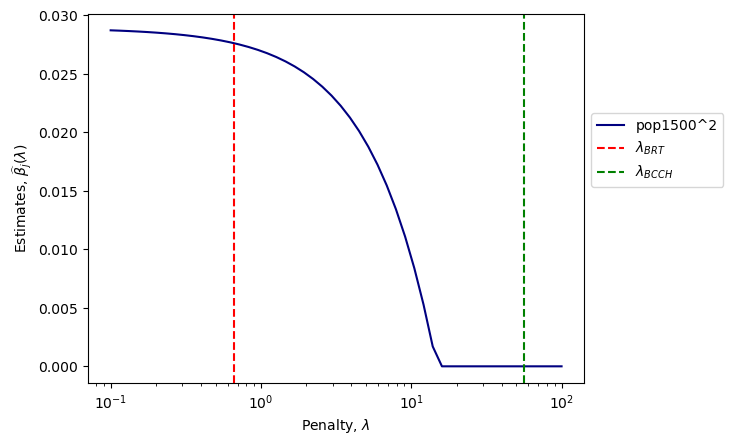

In [21]:
df = pd.DataFrame(dict(zip(penalty_grid,coefs)), index=var_names_poly[1:])   # every var_name except for initial gdp
df.loc[(df!=0).any(axis=1)].T.plot(logx=True, colormap='jet')           # Keeping every variable not equal to zero
plt.xlabel('Penalty, $\lambda$')
plt.ylabel(r'Estimates, $\widehat{\beta}_j(\lambda)$')
plt.axvline(penalty_BRT_single, linestyle='--', color='r', label=r'$\lambda_{BRT}$')
plt.axvline(penalty_BCCH_single, linestyle='--', color='g', label=r'$\lambda_{BCCH}$') 
plt.legend(loc='best', bbox_to_anchor=(1,0.75))
plt.savefig(f'lasso_path.pdf', bbox_inches = "tight")

In [22]:
df = pd.DataFrame(X_poly, columns=var_names_poly) # make a DataFrame

# Make OLS regression based on single approach
y0_single = df['lgdp_initial'].values.reshape(-1,1)
z_single = df['pop1500^2'].values.reshape(-1,1)       # pop_1500^2 is the last var to survive
x_single = np.hstack((y0_single,z_single))
LS = np.linalg.inv(x_single.T@x_single)@x_single.T@y

res_OLS = y-x_single@LS
SSR = res_OLS.T@res_OLS 
SST = (y - np.mean(y)).T@(y - np.mean(y))

# compute OLS standard errors
N = x_single.shape[0]
K = x_single.shape[1]
sigma2_ols = SSR/(N-K)
var = sigma2_ols*np.linalg.inv(x_single.T@x_single)
se_ols = np.sqrt(var.diagonal()).reshape(-1,1)

# pull out relevant coefficient and se estimates
# X=np.hstack((d,Z)) --> we are interested in d
se_ols_d = se_ols[0][0]
LS_d = LS[0][0].round(2)

# construct CI
q = norm.ppf(1-0.025)
CI_OLS =  ((LS_d+q*se_ols_d).round(2), (LS_d-q*se_ols_d).round(2)) 

### 4.2. Lasso with Cross Validation 

Would avoid CV, as we have such a small dataset...(?)

## 5. Post-Lasso

Suppose a model:

$$
Y=\alpha_0 D+Z^{\prime} \gamma_0+\varepsilon, \quad \mathrm{E}[\varepsilon \mid D, Z]=0
$$

### 5.1 Post Double Lasso

$$
\hat{\alpha}=\frac{\sum_{i=1}^N\left(Y_i-\mathbf{Z}_{i, J, Y} \hat{\boldsymbol{\phi}}\right)\left(D_i-\mathbf{Z}_{i, J, D} \hat{\boldsymbol{\delta}}\right)}{\sum_{i=1}^N\left(D_i-\mathbf{Z}_{i, J, D} \hat{\boldsymbol{\delta}}\right) D_i}=\frac{\sum_{i=1}^N \hat{u}_i \hat{w}_i}{\sum_{i=1}^N \hat{w}_i D_i}
$$

1) Lasso `gdp_growth` on controls $z_i$. Save residuals.
2) Lasso `initial_gdp` on controls $z_i$. Save residuals
    - Lasso `gdp_growth` on $\mathbf{X_i}$=(`initial_gdp`, $z_i$)
3) Calculate $\hat{\alpha}$
4) Calculate (implied) variance 
    - LASSO `gdp_growth` on X=((beta,z_i)). Save residuals
5) Calculate confidence interval

In [23]:
#BRT penalty
PDL_BRT, penalty_BRT_yz, penalty_BRT_bz, CI_PDL_BRT, se_PDL_BRT, coefs_PDL_BRT_stage1, coefs_PDL_BRT_stage2, N_BRT, p_BRT = hd.post_double_LASSO(X_tilde=X_tilde_poly, Z_tilde=X_tilde_poly[:, 1:], d=y0, y=y, penalty='BRT', fit_intercept=True)

#BCCH penalty
PDL_BCCH, penalty_BCCH_yz, penalty_BCCH_bz, CI_PDL_BCCH, se_PDL_BCCH, coefs_PDL_BCCH_stage1, coefs_PDL_BCCH_stage2, N_BCCH, p_BCCH = hd.post_double_LASSO(X_tilde=X_tilde_poly, Z_tilde=X_tilde_poly[:, 1:], d=y0, y=y, penalty='BCCH', fit_intercept=True)

In [24]:
LS_d

0.18

In [25]:
# Q: Include count of non-zero coefficients?

# Collect results in table
results = {
    'Penalty':                  [r'\texttt{BRT}', r'\texttt{BCCH}', r'\texttt{BRT}'],
    'Est.':                     [PDL_BRT, PDL_BCCH, LS_d], 
    'se':                       [se_PDL_BRT, se_PDL_BCCH, se_ols_d],
    'CI':                       [f'{CI_PDL_BRT}', f'{CI_PDL_BCCH}', f'{CI_OLS}'], 
    r'$\hat{\lambda}_{1}$':     [penalty_BRT_yz, penalty_BCCH_yz, penalty_BRT_single], 
    r'$\hat{\lambda}_{2}$':     [penalty_BRT_bz, penalty_BCCH_bz, '.'], 
    'N':                        [N, N, N],
    'p':                        [p, p, p],
    r'$\hat{s}_1$':             [np.count_nonzero(coefs_PDL_BRT_stage1), np.count_nonzero(coefs_PDL_BCCH_stage1), np.count_nonzero(coeff_BRT_single)],
    r'$\hat{s}_2$':             [np.count_nonzero(coefs_PDL_BRT_stage2), np.count_nonzero(coefs_PDL_BCCH_stage2), '.']         
}

print(pd.DataFrame(results, index=['PDL','PDL', 'PSL']).round(2).to_latex(escape=False))

\begin{tabular}{llrrlrlrrrl}
\toprule
{} &        Penalty &  Est. &    se &              CI &  $\hat{\lambda}_{1}$ & $\hat{\lambda}_{2}$ &   N &    p &  $\hat{s}_1$ & $\hat{s}_2$ \\
\midrule
PDL &   \texttt{BRT} & -0.21 &  0.02 &  (-0.25, -0.17) &                 0.66 &                0.61 &  90 &  527 &            1 &           1 \\
PDL &  \texttt{BCCH} & -0.12 &  0.01 &   (-0.14, -0.1) &                55.93 &               22.74 &  90 &  527 &            0 &           0 \\
PSL &   \texttt{BRT} &  0.18 &  0.02 &    (0.22, 0.14) &                 0.66 &                   . &  90 &  527 &            1 &           . \\
\bottomrule
\end{tabular}



C:\Users\JBH\AppData\Local\Temp\ipykernel_20884\4108098266.py:17: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(results, index=['PDL','PDL', 'PSL']).round(2).to_latex(escape=False))


In [26]:
all_vars

['gdp_growth',
 'lgdp_initial',
 'pop_growth',
 'investment_rate',
 'demreg',
 'temp',
 'elevavg',
 'precip',
 'area',
 'abslat',
 'cenlong',
 'area_ar',
 'rough',
 'landlock',
 'africa',
 'asia',
 'oceania',
 'americas',
 'pdiv',
 'pdiv_aa',
 'pd1500',
 'pop1500',
 'pprotest',
 'pcatholic',
 'pmuslim',
 'yellow',
 'uvdamage',
 'oilres',
 'goldm',
 'iron',
 'silv',
 'zinc']

### Addendum

